In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

df = pd.read_csv("C:/portfolio/retail-basket-pairs/data/products.csv")

df['product_list'] = df['Products'].str.split(', ')
df['basket_size'] = df['product_list'].str.len()

def get_pairs_from_basket(basket):
    if len(basket) < 2:
        return []
    return list(combinations(sorted(basket), 2))

df['pairs'] = df['product_list'].apply(get_pairs_from_basket)

pairs_df = df.explode('pairs').dropna(subset=['pairs']).reset_index(drop=True)
pairs_df[['item1', 'item2']] = pd.DataFrame(pairs_df['pairs'].tolist(), index=pairs_df.index)
pairs_df = pairs_df[['TransactionID', 'item1', 'item2']].copy()

pair_metrics = (
    pairs_df.groupby(['item1', 'item2'])
    .agg(
        pair_count=('TransactionID', 'size'),
        transactions=('TransactionID', 'nunique'),
    )
    .reset_index()
)

total_transactions = df['TransactionID'].nunique()
pair_metrics['frequency_pct'] = (pair_metrics['transactions'] / total_transactions * 100).round(2)

pair_metrics.head(20)

,item1,item2,pair_count,transactions,frequency_pct
0,Apple,Banana,783,783,2.61
1,Apple,Beans,777,777,2.59
2,Apple,Bread,745,745,2.48
3,Apple,Butter,766,766,2.55
4,Apple,Cereal,1065,1065,3.55
5,Apple,Cheese,815,815,2.72
6,Apple,Chicken,812,812,2.71
7,Apple,Chickpeas,846,846,2.82
8,Apple,Chips,723,723,2.41
9,Apple,Chocolate,785,785,2.62


In [6]:
all_products = sorted(
    set(
        prod
        for basket in df['product_list']
        for prod in basket
    )
)
len(all_products), list(all_products)[:10]

price_rules = [
    
    ("Milk",      "Dairy",        70,  150, 0.15, 0.30),
    ("Cheese",    "Dairy",       150, 400, 0.20, 0.35),
    ("Yogurt",    "Dairy",        60, 140, 0.15, 0.30),

    ("Bread",     "Bakery",       40, 120, 0.20, 0.35),
    ("Flatbread", "Bakery",       60, 180, 0.20, 0.35),
    ("Cracker",   "Bakery",       50, 160, 0.25, 0.40),
    ("Cake",      "Bakery",      150, 350, 0.25, 0.40),

    ("Apple",     "FruitVeg",     50, 120, 0.20, 0.35),
    ("Banana",    "FruitVeg",     40, 100, 0.20, 0.35),
    ("Orange",    "FruitVeg",     50, 120, 0.20, 0.35),
    ("Tomato",    "FruitVeg",     40, 110, 0.20, 0.35),
    ("Cucumber",  "FruitVeg",     40, 110, 0.20, 0.35),
    ("Beans",     "FruitVeg",     50, 140, 0.20, 0.35),

    ("Soda",      "Beverage",     60, 150, 0.25, 0.40),
    ("Juice",     "Beverage",     70, 180, 0.25, 0.40),
    ("Tea",       "Beverage",     80, 200, 0.25, 0.40),
    ("Coffee",    "Beverage",    150, 400, 0.30, 0.45),

    ("Chocolate", "Confection",   50, 200, 0.30, 0.45),
    ("Ice Cream", "Confection",   80, 250, 0.30, 0.45),
    ("Chips",     "Confection",   40, 140, 0.30, 0.45),

    ("Shampoo",   "NonFood",     150, 500, 0.25, 0.45),
    ("Soap",      "NonFood",      60, 200, 0.25, 0.45),
    ("Detergent", "NonFood",     150, 600, 0.25, 0.45),
    ("Sponge",    "NonFood",      40, 120, 0.25, 0.45),

    ("Cereal",    "Grocery",     100, 250, 0.25, 0.40),
    ("Rice",      "Grocery",      80, 220, 0.20, 0.35),
    ("Pasta",     "Grocery",      70, 200, 0.20, 0.35),
    ("Chicken",   "Meat",        150, 400, 0.20, 0.35),
    ("Fish",      "Meat",        150, 450, 0.20, 0.35),
]

In [8]:
all_products = sorted(
    set(prod for basket in df['product_list'] for prod in basket)
)

np.random.seed(42)

def assign_price_and_margin(product_name):
    for key, category, p_min, p_max, m_min, m_max in price_rules:
        if key in product_name:
            price = np.random.randint(p_min, p_max + 1)
            margin_pct = np.random.uniform(m_min, m_max)
            cost = round(price * (1 - margin_pct), 2)
            margin = round(price - cost, 2)
            return category, price, cost, margin
    price = np.random.randint(50, 201)
    margin_pct = np.random.uniform(0.15, 0.35)
    cost = round(price * (1 - margin_pct), 2)
    margin = round(price - cost, 2)
    return "Other", price, cost, margin

products_price2 = pd.DataFrame({'Product': all_products})
products_price2[['category', 'price', 'cost', 'margin_per_unit']] = (
    products_price2['Product'].apply(
        lambda x: pd.Series(assign_price_and_margin(x))
    )
)

top20_frequent_pairs = (
    pair_metrics
    .sort_values('transactions', ascending=False)
    .head(20)
    .reset_index(drop=True)
)

top20_frequent_pairs[['item1', 'item2', 'pair_count', 'transactions', 'frequency_pct']]

,item1,item2,pair_count,transactions,frequency_pct
0,Cereal,Milk,2852,2852,9.51
1,Cereal,Cheese,1192,1192,3.97
2,Cereal,Soda,1182,1182,3.94
3,Cereal,Ice Cream,1177,1177,3.92
4,Cereal,Chocolate,1168,1168,3.89
5,Cereal,Juice,1167,1167,3.89
6,Butter,Cereal,1162,1162,3.87
7,Beans,Cereal,1160,1160,3.87
8,Cereal,Cucumber,1158,1158,3.86
9,Cereal,Fish,1156,1156,3.85


In [23]:
products_price.to_csv("C:/portfolio/retail-basket-pairs/data/products_price_margin.csv", index=False)

In [25]:
pair_with_margin2 = (
    pair_metrics
    .merge(products_price2, left_on='item1', right_on='Product', how='left')
    .rename(columns={
        'price': 'price_1',
        'cost': 'cost_1',
        'margin_per_unit': 'margin_1',
        'category': 'category_1'
    })
    .drop(columns=['Product'])
    .merge(products_price2, left_on='item2', right_on='Product', how='left')
    .rename(columns={
        'price': 'price_2',
        'cost': 'cost_2',
        'margin_per_unit': 'margin_2',
        'category': 'category_2'
    })
    .drop(columns=['Product'])
)

pair_with_margin2['pair_margin_per_txn'] = (pair_with_margin2['margin_1'] + pair_with_margin2['margin_2']).round(2)
pair_with_margin2['total_pair_margin'] = (
    pair_with_margin2['pair_margin_per_txn'] * pair_with_margin2['transactions']
).round(2)

top20_margin_pairs2 = (
    pair_with_margin2
    .sort_values('total_pair_margin', ascending=False)
    .head(20)
    .reset_index(drop=True)
)

top20_margin_pairs2[['item1', 'item2', 'transactions', 'pair_margin_per_txn', 'total_pair_margin']]

,item1,item2,transactions,pair_margin_per_txn,total_pair_margin
0,Cereal,Shampoo,1122,196.07,219990.54
1,Cereal,Milk,2852,73.39,209308.28
2,Detergent,Shampoo,761,256.02,194831.22
3,Cereal,Detergent,1067,176.37,188186.79
4,Fish,Shampoo,782,221.65,173330.30
5,Chicken,Shampoo,819,209.04,171203.76
6,Cereal,Fish,1156,142.00,164152.00
7,Shampoo,Soap,838,193.71,162328.98
8,Detergent,Fish,755,201.95,152472.25
9,Cheese,Shampoo,825,184.41,152138.25


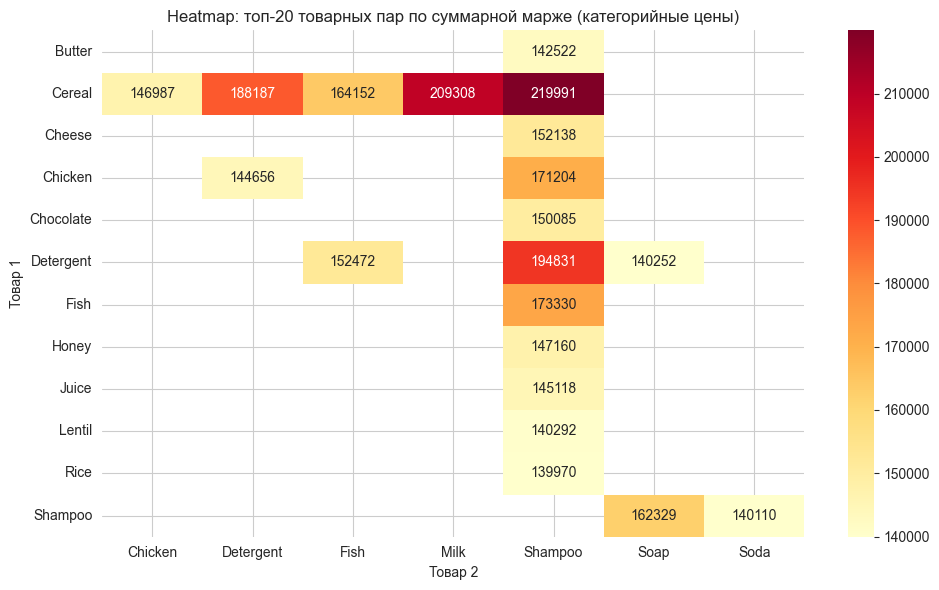

In [26]:

heatmap_data2 = top20_margin_pairs2.pivot(
    index='item1',
    columns='item2',
    values='total_pair_margin'
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data2,
    annot=True,
    fmt='.0f',
    cmap='YlOrRd'
)
plt.title("Heatmap: топ-20 товарных пар по суммарной марже (категорийные цены)")
plt.xlabel("Товар 2")
plt.ylabel("Товар 1")
plt.tight_layout()
plt.show()
